## pytorch stuff

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from SlidingWindow import SlidingWindowDataset
from models import LSTM
from training import *
from sklearn.metrics import confusion_matrix

def split_data_labels(dataset_train):
    labels = dataset_train["Label"]
    dataset_train = dataset_train.drop("Label", axis=1)

    return dataset_train, labels

In [2]:
df_train_set = pd.read_csv("../data/train_onlyAngles.csv", )
df_test_set = pd.read_csv("../data/test_onlyAngles.csv")
df_train_data, labels = split_data_labels(df_train_set)
df_test_data, file_id = split_data_labels(df_test_set)

train_data_scaled = StandardScaler().fit_transform(df_train_data)
test_data_scaled = StandardScaler().fit_transform(df_test_data)

X_train, X_val, y_train, y_val = train_test_split(train_data_scaled, labels, test_size=0.2, random_state=42,
                                                    shuffle=False)

train_set = SlidingWindowDataset(X_train, y_train, window_size=100, step_size=50)
val_set = SlidingWindowDataset(X_val, y_val, window_size=100, step_size=50)

test_set = SlidingWindowDataset(test_data_scaled, file_id, window_size=100, step_size=50)

In [3]:
# Connect to GPU
if torch.cuda.is_available():
    DEVICE = "cuda"
    # Clear cache if non-empty
    torch.cuda.empty_cache()
    # See which GPU has been allotted
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    DEVICE = "cpu"
    print("On CPU")


NVIDIA GeForce RTX 3070


Epoch: 01/01


100%|██████████| 21/21 [00:00<00:00, 122.81it/s]


Train Loss: 1.353 | Train Acc: 44.82%
Val. Loss: 1.173 | Val. Acc: 55.70%


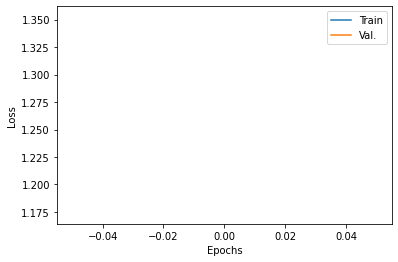

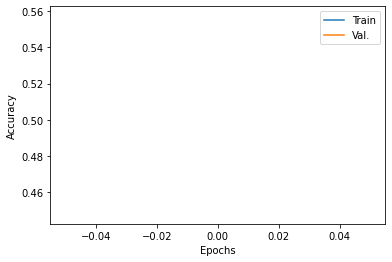

In [4]:
lstm = LSTM(input_size=12, hidden_size=128, num_layers=2)

lstm = lstm.to(DEVICE)
lstm, (train_acc, val_acc), = train_model(lstm, epochs=1, batch_size=128, learning_rate=0.01, train_set=train_set, val_set=val_set,
                        device=DEVICE)

In [13]:
torch.save(lstm.state_dict(), "../models/lstm_model_{val_acc:.0f}.pt".format(val_acc=val_acc*100))

In [18]:
classifications = []

dl_test = DataLoader(test_set, 1, shuffle=False)

for inputs, file_id in dl_test:  
  torch.cuda.empty_cache()
  inputs = inputs.to(DEVICE)
  classifications.append([file_id.item(), torch.argmax(lstm(inputs), 1).item()]) 

In [21]:
dl_test = DataLoader(test_set, 32, shuffle=False)

for inputs, file_id in dl_test:  
    print(inputs.shape)
    print(file_id)
    break

torch.Size([32, 100, 12])
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1, 10, 10, 10, 10, 10, 10, 10, 10, 10])


In [ ]:
pd.DataFrame(classifications, columns=["id", "action"]).groupby("id").agg(lambda x: x.value_counts().index[0]).reset_index().to_csv("../Results/LSTMtorch/submission_lstm_pytorch_val{val_acc:.0f}.csv".format(val_acc*100), index=False, sep=",")

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label/naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
#plot_confusion_matrix(confusion_matrix(val_set.y, [item[1] for item in classifications]), None, normalize=False)

In [ ]:
## compare csvs

predictions_LSTM = pd.read_csv("../Results/LSTMtorch/submission_lstm_pytorch_98acc.csv", names=["id", "action"])
predictions_chris = pd.read_csv("C:/Users/Jochen/Downloads/2023-01-02_19-54-28_submission.csv", names=["id", "action"])

percentage = len(pd.concat([predictions_chris,predictions_LSTM]).drop_duplicates(keep=False)) / len(predictions_chris) * 100
percentage

## tried tensorflow...didnt work

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import helpers
import utils
from dataset import *
#from models import *
from resnets import resnet18, resnet34

tf.random.set_seed(28)
np.random.seed(28)

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, train, test, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(X_train, y_train, epochs=MAX_EPOCHS,
                      validation_data=(X_val, y_val),
                      callbacks=[early_stopping])
  return history

In [ ]:
Pr = helpers.ProgramRuntime()

try:

    # df_train, df_test = read_csvs()
    df_train_set = pd.read_csv("data/train_onlyAngles.csv", )
    df_test_set = pd.read_csv("data/test_onlyAngles.csv")
    df_train_data, labels = split_data_labels(df_train_set)
    df_test_data, labels_test = split_data_labels(df_test_set)

    train_data_scaled = StandardScaler().fit_transform(df_train_data)
    test_data_scaled = StandardScaler().fit_transform(df_test_data)
    
    X_train, X_test, y_train, y_test = train_test_split(train_data_scaled, labels, test_size=0.2, random_state=42, shuffle=False)
    
    dataset_sw, labels_list = sliding_window(train_data_scaled, labels, 100, 50)

    
    # Hyperparameter
    epochs = 2  # 500    # For testing 2
    batch_size = 256
    verbose = 1
    lr = 0.001

        # Hardware config
    strategy = helpers.hardware_config("GPU")
    
    wnd_train_data = tf.keras.utils.timeseries_dataset_from_array(
        data=X_train,
        targets=y_train,
        sequence_length=100,
        sequence_stride=50,
        shuffle=False,
        batch_size=16)

    wnd_test_data = tf.keras.utils.timeseries_dataset_from_array(
        data=X_test,
        targets=y_test,
        sequence_length=100,
        sequence_stride=50,
        shuffle=False,
        batch_size=16)


    # define a sequential model
    model = tf.keras.models.Sequential([ 
        #tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[12]),
        tf.keras.layers.InputLayer(input_shape=[None, 12]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(1),
    ]) 

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.Accuracy()])

    history = model.fit(wnd_train_data, epochs=2,
                      validation_data=wnd_test_data,
                      callbacks=[early_stopping])

    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='mae')
    plt.plot(history.history['loss'], label='loss')
    plt.legend()
    plt.show()



    # comment in for cnn_net
    # dataset_sw, dataset_sw_test = reshape_cnn(dataset_sw, dataset_sw_test)

    # comment in for conv_lstm_net
    # dataset_sw, dataset_sw_test = reshape_conv_lstm(dataset_sw, dataset_sw_test)

    #train(dataset_sw, np.array(labels_list), dataset_sw_test, np.array(labels_list_test))
    # train_entire_data(dataset_sw, np.array(labels_list), dataset_sw_test, np.array(labels_list_test))
    

except Exception as e:
    print(e)
finally:
    runtime = Pr.finish(print=True)

In [ ]:
wnd_train_data = tf.keras.utils.timeseries_dataset_from_array(
    data=X_train,
    targets=y_train,
    sequence_length=100,
    sequence_stride=50,
    shuffle=False,
    batch_size=16)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
history = compile_and_fit(lstm_model, wnd_train_data, wnd_test_data)
